<a href="https://colab.research.google.com/github/autumnjohnson/deepul/blob/develop/hw2_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
!unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul
from deepul.hw2_helper import *

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


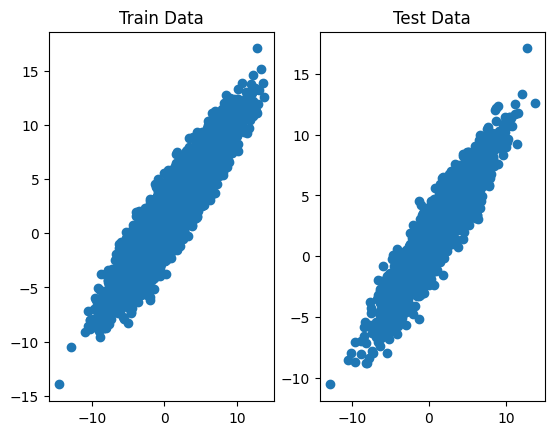

Dataset 2


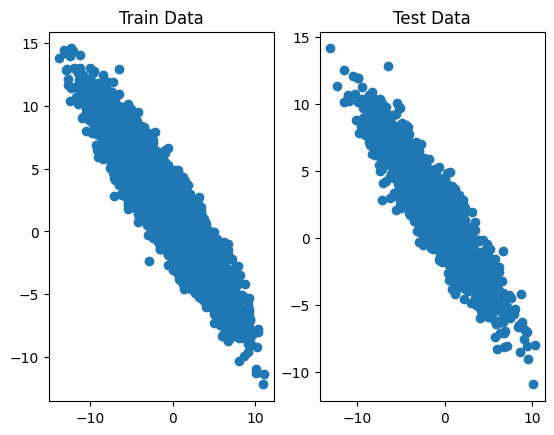

In [215]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [216]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [217]:
# For logging metrics
class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
    def on_train_batch_end(self, batch, logs=None):
        self.train_losses.append([logs['elbo'], logs["loss"], logs["kullback_leibler_divergence"]])

    def on_test_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average loss is {:7.2f}.".format(batch, logs["loss"])        )

    def on_epoch_end(self, epoch, logs=None):
        self.test_losses.append([logs['elbo'], logs["loss"], logs["kullback_leibler_divergence"]])
        print("Ror epoch {} the reconstruction loss is {:7.2f} and KL is {:7.2f}.".format(epoch, logs["loss"], logs["kullback_leibler_divergence"]))

In [225]:
def kl_loss(x,y):
    return tf.keras.losses.KLDivergence()(x, y)

def elbo(x, y):
    result = tf.reduce_mean(tfd.Normal(x, 1).log_prob(y))
    return -result


def loss_func(x, y):
    return kl_loss(x, y) + elbo(x, y)

class Sampler(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, logvar = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(logvar)[1]
        epsilon = keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * logvar) * epsilon

class Decoder(tf.Module):

    def __init__(self, latent_dim, input_shape, name = "vae_decoder"):
        super().__init__()
        self.decoder_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(tf.math.reduce_prod(input_shape), activation='sigmoid'),
            tf.keras.layers.Reshape(input_shape)
        ])

    def __call__(self, inputs):
        return self.decoder_layers(inputs)


class VAE(tf.keras.Model):
    def __init__(self,  latent_dim, input_shape, name = None):
        super().__init__(name=name)
        self.latent_dim = latent_dim

        self.decoder = Decoder(latent_dim, input_shape, name='decoder')
        self.encoder =  tf.keras.Sequential([
            tf.keras.layers.Input(shape = input_shape),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim * 2, activation='relu'),

        ])
        self.z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")



        self.sampler = Sampler()

    def reparameterize(self, mean, logvar):

        eps = np.random.normal(mean, logvar)

        return eps * tf.exp(logvar * .5) + mean

    # Prior distribution
    def sample(latent_dim, noise=False):
      #  prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))
        return tfd.MultivariateNormalDiag(loc=self.mean_val, scale=self.logvar_val)

    def call(self, inputs, training=None):
        z = self.encoder(inputs)

        self.mean_val = self.z_mean(z)
        self.logvar_val = self.z_log_var(z)

        z = self.sampler([self.mean_val, self.logvar_val])
        decoded = self.decoder(z)

        return decoded

In [228]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """
    epochs = 10
    batch_size = 128
    lr = 1e-4
    latent_dim = 2
    input_shape =train_data[0].shape
    test_loader= tf.data.Dataset.from_tensor_slices(test_data)
    train_loader = tf.data.Dataset.from_tensor_slices(train_data)
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    metrics =[elbo,'kullback_leibler_divergence', 'mean_absolute_error']

    vae = VAE(latent_dim, input_shape, name='vae')

    vae.compile(optimizer=optimizer, metrics=metrics,loss=loss_func)
    metrics_callback = LossAndErrorPrintingCallback()
    # Trains the variational autoencoder
    history = (vae.fit(train_data, train_data, callbacks=[metrics_callback],epochs=epochs, batch_size=batch_size, shuffle=True))
    print(vae.summary())
    results = vae.get_metrics_result().values()

    train_losses = np.array(metrics_callback.train_losses)
    test_losses =  np.array(metrics_callback.test_losses)
    samples_noise = test_data
    samples = samples_noise
    xhat = vae.predict(test_data)

    return train_losses, test_losses, xhat, samples

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Epoch 1/10
79/79 [==============================] - 2s 6ms/step - loss: 8.5687 - elbo: 7.8044 - kullback_leibler_divergence: 0.7650 - mean_absolute_error: 2.9484
Epoch 2/10
79/79 [==============================] - 1s 6ms/step - loss: 8.5476 - elbo: 7.7764 - kullback_leibler_divergence: 0.7590 - mean_absolute_error: 2.9437
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 8.5310 - elbo: 7.8031 - kullback_leibler_divergence: 0.7512 - mean_absolute_error: 2.9412
Epoch 4/10
79/79 [==============================] - 0s 4ms/step - loss: 8.5111 - elbo: 7.8089 - kullback_leibler_divergence: 0.7421 - mean_absolute_error: 2.9379
Epoch 5/10
79/79 [==============================] - 0s 4ms/step - loss: 8.4892 - elbo: 7.7358 - kullback_leibler_divergence: 0.7305 - mean_absolute_error: 2.9353
Epoch 6/10
79/79 [==============================] - 0s 4ms/step - loss: 8.4783 - elbo: 7.7856 - kullback_leibler_divergence: 0.7254 - mean_absolute_error: 2.9345
Epoch 7/10
79/79 [==========

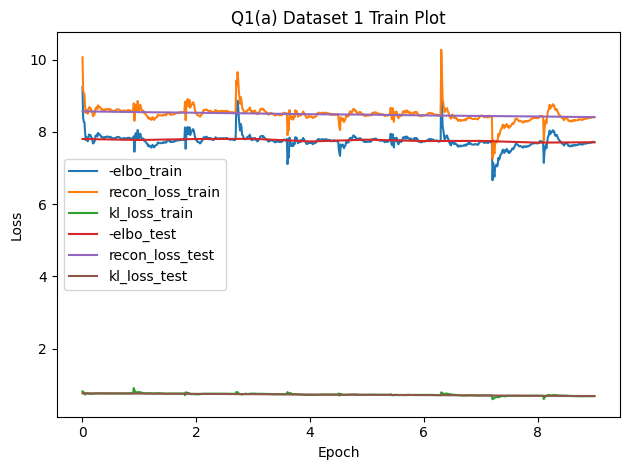

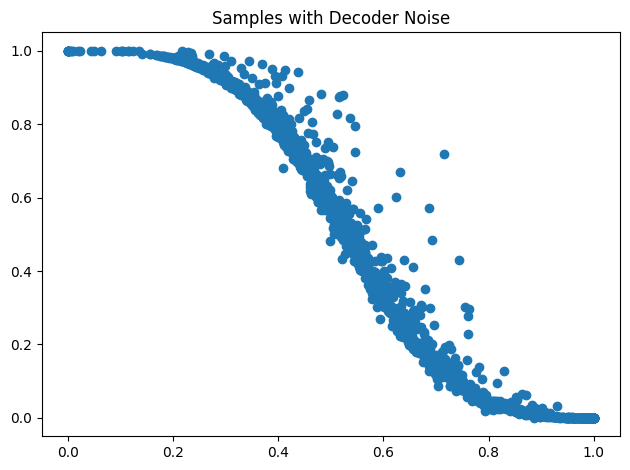

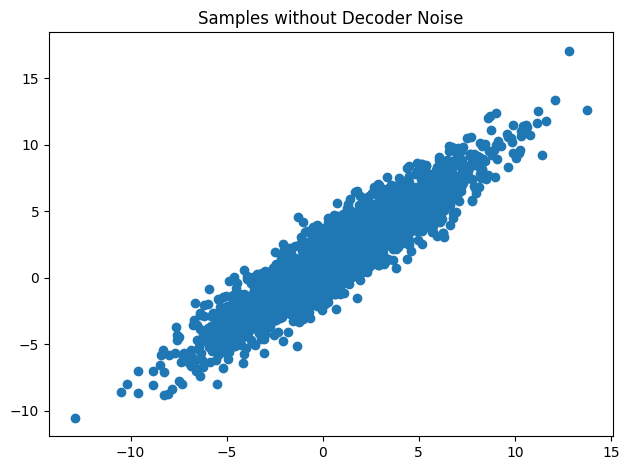

In [229]:
q1_save_results('a', 1, q1)

Epoch 1/10
79/79 [==============================] - 2s 4ms/step - loss: 9.4288 - elbo: 8.5443 - kullback_leibler_divergence: 0.8677 - mean_absolute_error: 3.1242
Epoch 2/10
79/79 [==============================] - 0s 4ms/step - loss: 9.2797 - elbo: 8.4623 - kullback_leibler_divergence: 0.7923 - mean_absolute_error: 3.1059
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 9.1689 - elbo: 8.3941 - kullback_leibler_divergence: 0.7335 - mean_absolute_error: 3.0940
Epoch 4/10
79/79 [==============================] - 0s 4ms/step - loss: 9.0876 - elbo: 8.3813 - kullback_leibler_divergence: 0.6951 - mean_absolute_error: 3.0838
Epoch 5/10
79/79 [==============================] - 0s 4ms/step - loss: 8.9774 - elbo: 8.3010 - kullback_leibler_divergence: 0.6464 - mean_absolute_error: 3.0695
Epoch 6/10
79/79 [==============================] - 0s 4ms/step - loss: 8.9091 - elbo: 8.2719 - kullback_leibler_divergence: 0.6175 - mean_absolute_error: 3.0593
Epoch 7/10
79/79 [==========

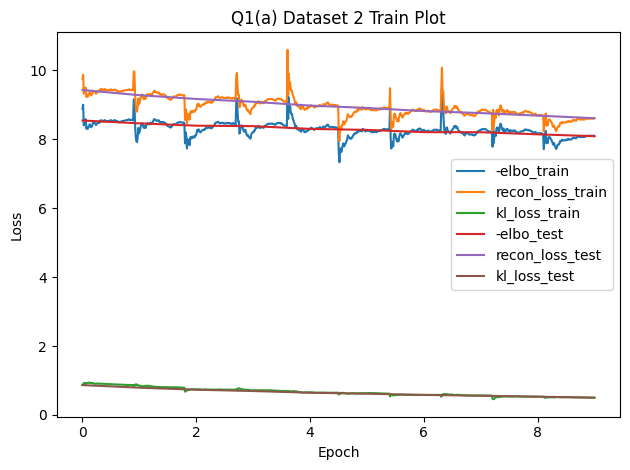

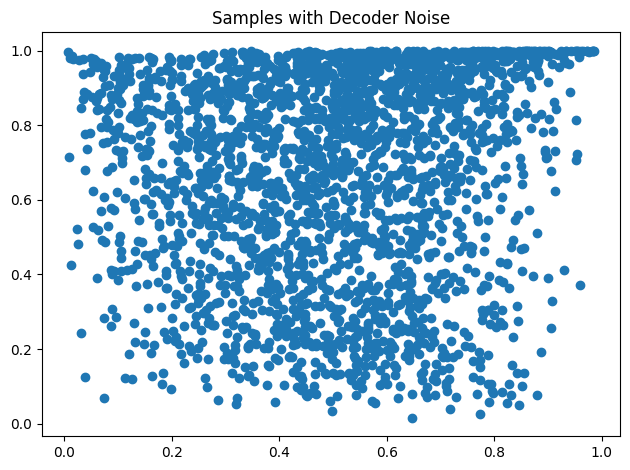

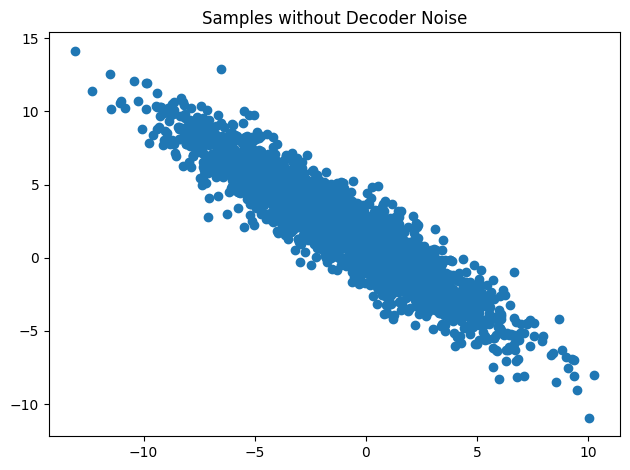

In [230]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


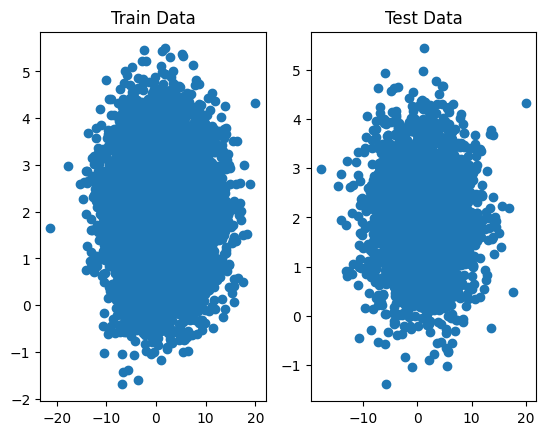

Dataset 2


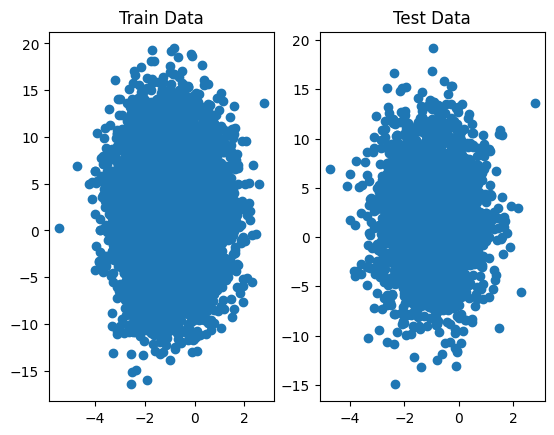

In [231]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Epoch 1/10
79/79 [==============================] - 2s 4ms/step - loss: 10.2482 - elbo: 7.9287 - kullback_leibler_divergence: 2.3142 - mean_absolute_error: 2.7856
Epoch 2/10
79/79 [==============================] - 0s 5ms/step - loss: 10.1397 - elbo: 7.8869 - kullback_leibler_divergence: 2.2160 - mean_absolute_error: 2.7805
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 9.9746 - elbo: 7.9027 - kullback_leibler_divergence: 2.0857 - mean_absolute_error: 2.7743
Epoch 4/10
79/79 [==============================] - 0s 4ms/step - loss: 9.8302 - elbo: 7.8559 - kullback_leibler_divergence: 1.9551 - mean_absolute_error: 2.7669
Epoch 5/10
79/79 [==============================] - 0s 4ms/step - loss: 9.6992 - elbo: 7.8420 - kullback_leibler_divergence: 1.8552 - mean_absolute_error: 2.7599
Epoch 6/10
79/79 [==============================] - 0s 4ms/step - loss: 9.5949 - elbo: 7.8595 - kullback_leibler_divergence: 1.7670 - mean_absolute_error: 2.7513
Epoch 7/10
79/79 [========

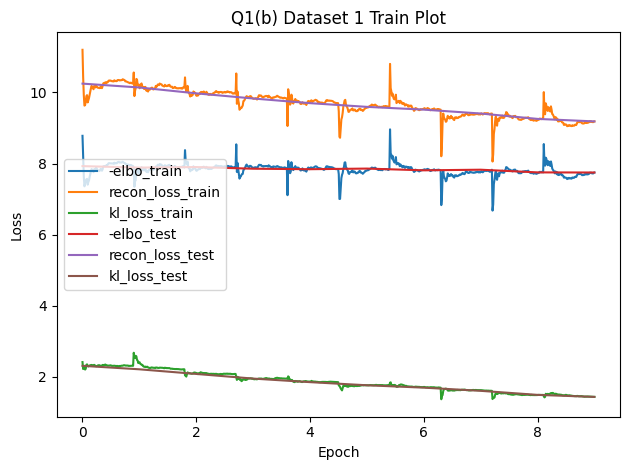

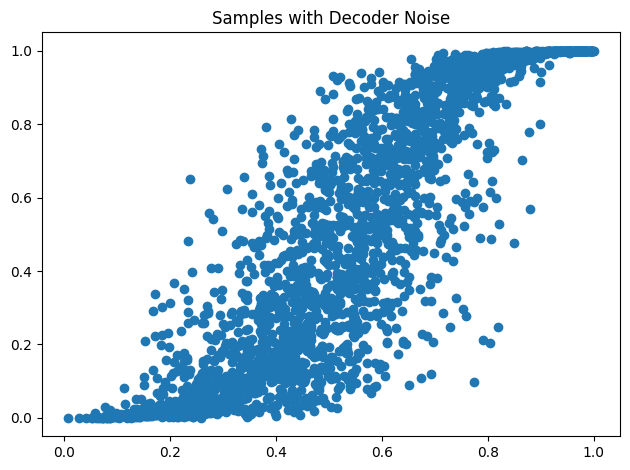

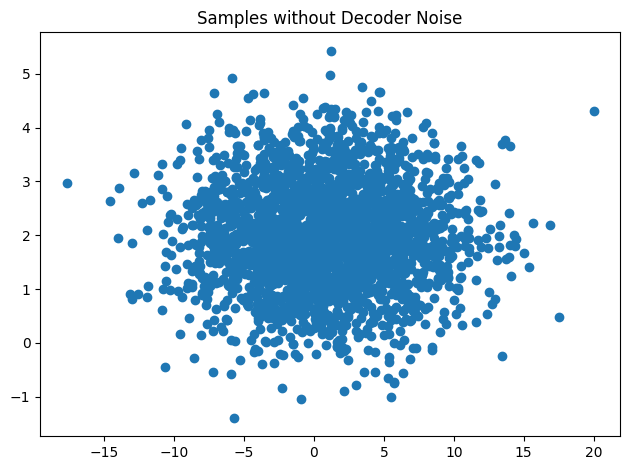

In [232]:
q1_save_results('b', 1, q1)

Epoch 1/10
79/79 [==============================] - 2s 4ms/step - loss: 8.5126 - elbo: 8.0743 - kullback_leibler_divergence: 0.4630 - mean_absolute_error: 2.7617
Epoch 2/10
79/79 [==============================] - 0s 4ms/step - loss: 8.4264 - elbo: 8.0257 - kullback_leibler_divergence: 0.4278 - mean_absolute_error: 2.7538
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 8.3357 - elbo: 7.9318 - kullback_leibler_divergence: 0.3900 - mean_absolute_error: 2.7423
Epoch 4/10
79/79 [==============================] - 0s 4ms/step - loss: 8.2528 - elbo: 7.9476 - kullback_leibler_divergence: 0.3589 - mean_absolute_error: 2.7303
Epoch 5/10
79/79 [==============================] - 0s 4ms/step - loss: 8.1811 - elbo: 7.8308 - kullback_leibler_divergence: 0.3347 - mean_absolute_error: 2.7218
Epoch 6/10
79/79 [==============================] - 0s 4ms/step - loss: 8.0990 - elbo: 7.7847 - kullback_leibler_divergence: 0.3034 - mean_absolute_error: 2.7102
Epoch 7/10
79/79 [==========

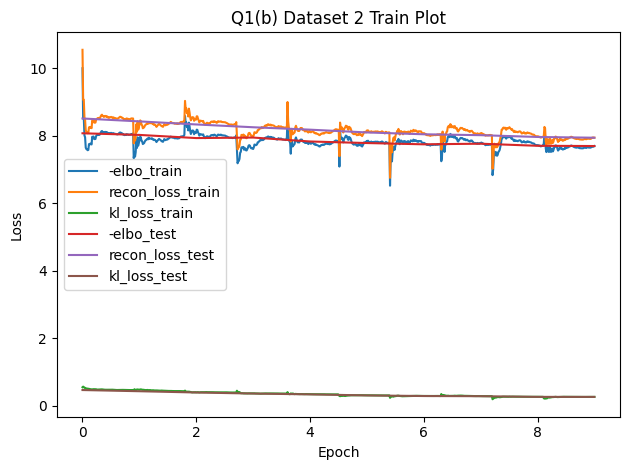

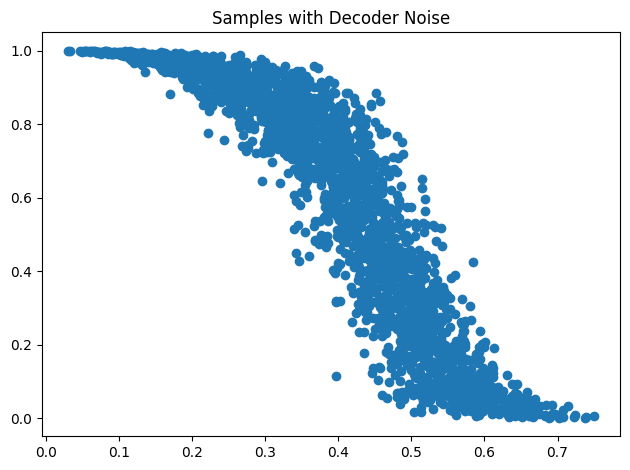

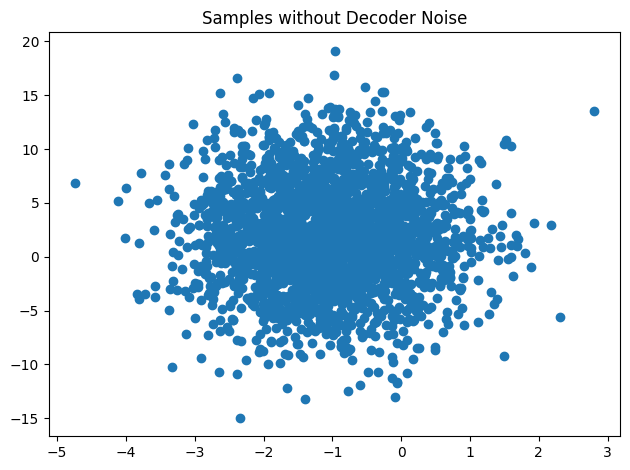

In [233]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

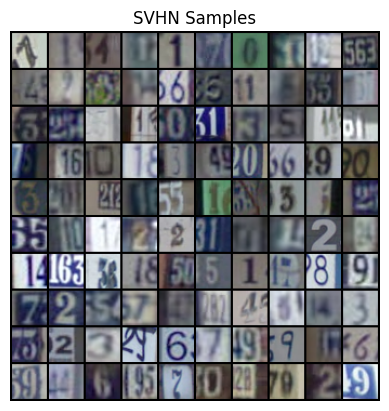

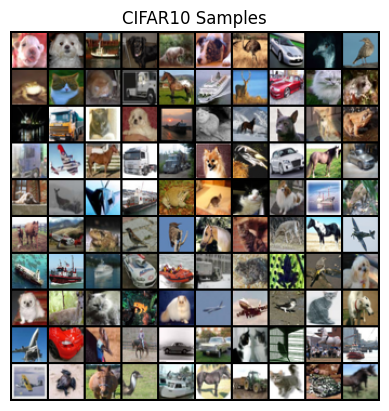

In [202]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [209]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    # Declare parameters
    latent_dim = 16
    batch_size = 128
    lr = .001
    epochs = 10
    img_input_shape = (32,32,3)

    # Normalize pixel values to be between 0,1
    train_data = (train_data / 255 - 0.5) * 2
    test_data = (test_data / 255 - 0.5) * 2
    # Load dataset
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    assert(np.ndim(train_loader.dataset) == 4)
    assert(np.ndim(train_data) == 4)

    # Initialize  model
    vae = VAE(latent_dim).to(device)
    print(vae)
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    mse_loss = torch.nn.MSELoss()
    kl_divergence_loss =  torch.nn.KLDivLoss(reduction='batchmean')

    batch_losses, epoch_losses = fit(train_loader, vae, optimizer, epochs)

    images_set1 = train_data[0:50]
    images_set2 = train_data[0:20]
    image_samples =  (vae.sample(100) + 1) * 255 / 2
    image_pairs = (vae.sample_pairs(images_set1) + 1) * 255 / 2
    image_interpolation = (vae.interpolation(images_set2) + 1) * 255 / 2

    return batch_losses, epoch_losses, image_samples,image_samples, image_samples

In [210]:
import torch
from deepul.hw2_helper import *
from torch.distributions.normal import Normal as Normal


In [211]:
class VAE(torch.nn.Module):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.sample_num = 2
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Define the encoder whose distribution is q(z|x)
        self.encoder_conv = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, 2, 1), # 16 x 16
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 3, 2, 1), # 8 x 8
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, 3, 2, 1), # 4 x 4
            torch.nn.ReLU())
        self.encoder_linear = torch.nn.Linear(4 * 4 * 256, 2 * self.latent_dim)
        #  torch.nn.Flatten(), # 16 torch.nn.Linear(4 * 4 * 256, 2 * latent_dim))

        # Define the decoder whose distribution is p(x|z)
        self.decoder_linear = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, 4 * 4 * 128),
            torch.nn.ReLU())
        #  Reshape(4, 4, 128),
        self.decoder_conv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 128, 4, 2, 1), # 8 x 8
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 x 16
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 x 32
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, 3, 1, 1))

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        outs = outs.reshape(batch_size, -1)
        u_z, log_sigma_z = torch.chunk(self.encoder_linear(outs), 2, dim=-1)
        u_z = u_z.unsqueeze(1).repeat(1, self.sample_num, 1)
        sigma_z = torch.exp(log_sigma_z).unsqueeze(1).repeat(1, self.sample_num, 1)
        epsilon = torch.normal(0, 1, size=(batch_size, self.sample_num, self.latent_dim)).to(self.device)
        z_samples = u_z + epsilon * sigma_z

        z_samples = z_samples.view(size=(-1, self.latent_dim))
        z_outs = self.decoder_linear(z_samples)
        z_outs = z_outs.view(size=(batch_size * self.sample_num, 128, 4, 4))
        z_outs = self.decoder_conv(z_outs)
        z_outs = z_outs.view(batch_size, self.sample_num, 3, 32, 32)
        log_p_theta = Normal(z_outs, 1).log_prob(x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1))
        log_p_z = Normal(0, 1).log_prob(z_samples).view(batch_size, self.sample_num, -1)
        log_q_phi = Normal(u_z, sigma_z).log_prob(z_samples.view(size=u_z.shape))
        mse_loss = (z_outs - x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1)) ** 2

        return log_p_theta.sum(dim=[2, 3, 4]), log_p_z.sum(dim=[2]), log_q_phi.sum(dim=[2]), mse_loss.sum(dim=[2, 3, 4]), z_outs

    def loss(self, x):
        losses = self(x)
        elbo = torch.mean(losses[2] - losses[1] + losses[3])
        reconstruction_loss = torch.mean(losses[3])
        kl_loss = torch.mean(losses[2] - losses[1])
        return elbo, reconstruction_loss, kl_loss

    def sample_pairs(self, x):
        pre_sample_num = self.sample_num
        self.sample_num = 1
        x = torch.from_numpy(x).to(self.device).float()
        with torch.no_grad():
            results = self(x)
            z_outs = torch.squeeze(results[-1])
            reconstructed_images = z_outs
        self.sample_num = pre_sample_num
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i], reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().data.numpy()

    def interpolation(self, x):
        batch_size = x.shape[0]
        x = torch.from_numpy(x)
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        outs = torch.reshape(outs, (batch_size, -1))#change
        u_z, _ = torch.chunk(self.encoder_linear(outs), 2, dim=-1)

        image_list = []
        lamda = [(i + 1) / 9 for i in range(8)]
        for i in range(10):
            image_list.append(x[2 * i].permute(1, 2, 0))
            for coeff in lamda:
                z_samples = (1 - coeff) * u_z[2 * i] + coeff * u_z[2 * i + 1]
                z_outs = self.decoder_linear(z_samples)
                z_outs = z_outs.view(size=(1, 128, 4, 4))
                z_outs = self.decoder_conv(z_outs)
                z_outs = z_outs.view(1, 3, 32, 32)
                image_list.append(z_outs[0].permute(1, 2, 0))
            image_list.append(x[2 * i + 1].permute(1, 2, 0))
        return torch.stack(image_list, dim=0).cpu().data.numpy()

    def sample(self, num_samples):
        with torch.no_grad():
            z_samples = torch.normal(0, 1, size=(num_samples, self.latent_dim)).to(self.device)
            z_outs = self.decoder_linear(z_samples)
            z_outs = z_outs.view(size=(num_samples, 128, 4, 4))
            z_outs = self.decoder_conv(z_outs)
            return z_outs.permute(0, 2, 3, 1).cpu().data.numpy()

In [212]:
def fit(data_loader, model, optimizer, epochs):
    batch_losses = []
    epoch_losses = []
    result = 0.
    for epoch in range(epochs):

        elbo, reconstruction_loss, kl_loss = 0., 0., 0.
        for i, batch in enumerate(data_loader):
            optimizer.zero_grad()
            result = model.loss(batch)
            loss = result[0]
            loss.backward()
            optimizer.step()

            elbo = (elbo + (loss.cpu().item() * batch.shape[0])) / len(batch)
            reconstruction_loss = (reconstruction_loss + (result[1].cpu().item() * batch.shape[0])) / len(batch)
            kl_loss = (kl_loss + (result[2].cpu().item() * batch.shape[0])) / len(batch)
            metrics = [elbo, reconstruction_loss, kl_loss]
            batch_losses.append(metrics)

        print("epoch: ", epoch, ", elbo: ", elbo,     ", reconn_loss: ", reconstruction_loss,", kl loss: ", kl_loss)

        assert(type(elbo) == float)
        assert(type(reconstruction_loss) == float)
        assert(type(kl_loss) == float)


        epoch_losses.append(metrics)

        # Record per epoch statistics

    print("epoch_losses length: ", len(epoch_losses))
    return  np.array(batch_losses, dtype=np.float32), np.array(epoch_losses, dtype=np.float32)

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (encoder_linear): Linear(in_features=4096, out_features=32, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=16, out_features=2048, bias=True)
    (1): ReLU()
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=

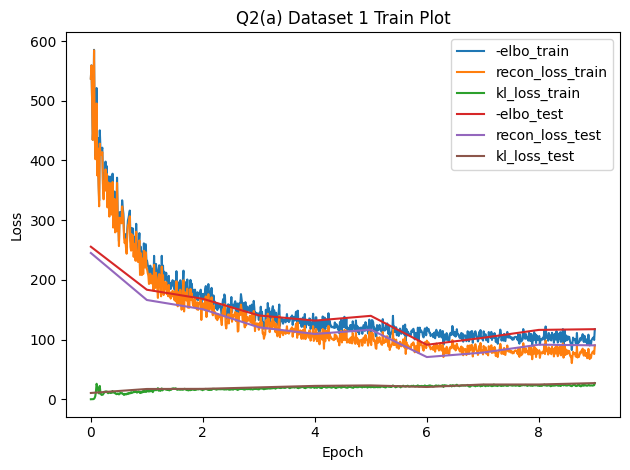

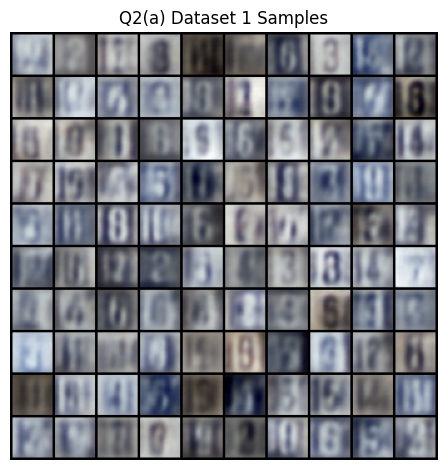

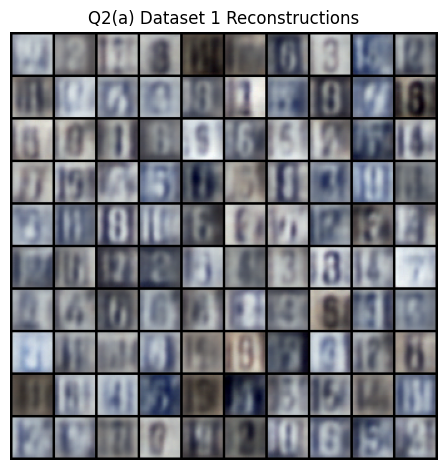

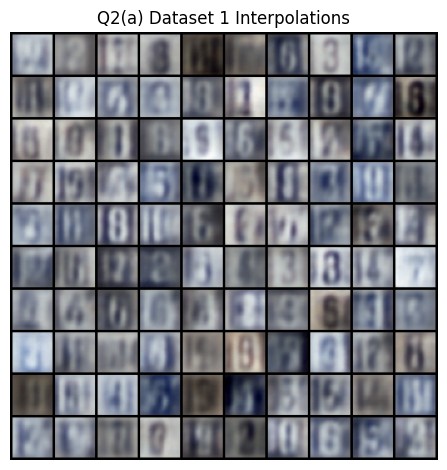

In [213]:
q2_save_results('a', 1, q2_a)

VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (encoder_linear): Linear(in_features=4096, out_features=32, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=16, out_features=2048, bias=True)
    (1): ReLU()
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=

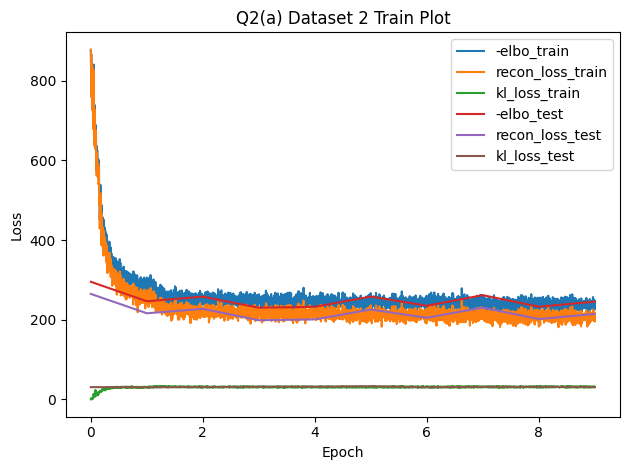

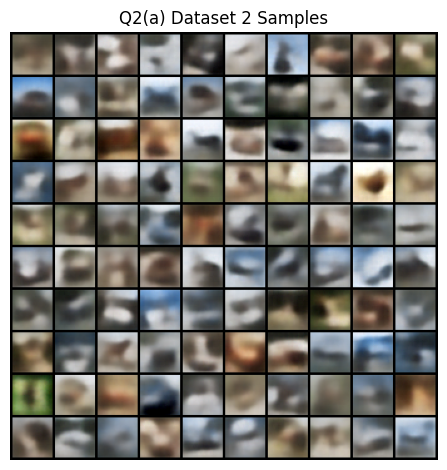

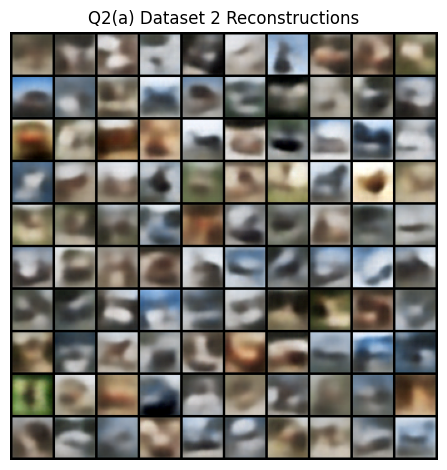

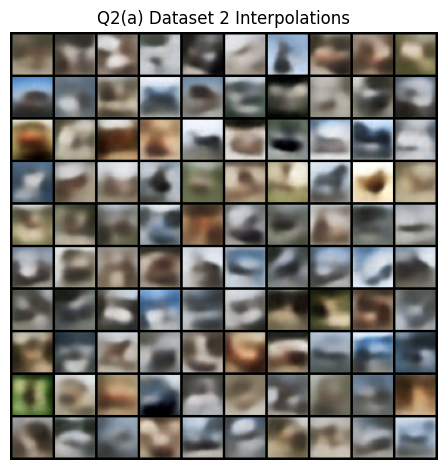

In [214]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
import torch
import torch.nn
import torch.nn.functional as F
class MaskedLinear(torch.nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(mask)

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class Made(torch.nn.Module):
    def __init__(self, masked_matrix_list, hidden_units):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.register_parameter("shift", nn.Parameter(torch.ones(size=(1, hidden_units[-1] // 2)), requires_grad=True))
        self.register_parameter("scale", nn.Parameter(torch.ones(size=(1, hidden_units[-1] // 2)), requires_grad=True))
        self.fc1 = MaskedLinear(hidden_units[0], hidden_units[1])
        self.fc1.set_mask(masked_matrix_list[0])
        self.fc2 = MaskedLinear(hidden_units[1], hidden_units[2])
        self.fc2.set_mask(masked_matrix_list[1])
        self.fc3 = MaskedLinear(hidden_units[2], hidden_units[3])
        self.fc3.set_mask(masked_matrix_list[2])
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.masked_matrix_list = masked_matrix_list
        self.latent_dim = hidden_units[-1] // 2

    def forward(self, inputs):
        inputs = inputs.to(self.device)
        outs = self.relu(self.fc1(inputs))
        outs = self.relu(self.fc2(outs))
        log_s, t = torch.chunk(self.relu(self.fc3(outs)), chunks=2, dim=-1)
        log_s = self.scale * self.tanh(log_s) + self.shift
        epsilon = inputs * torch.exp(log_s) + t
        log_p_epsilon = Normal(0, 1).log_prob(epsilon)
        log_det = log_s
        return log_p_epsilon + log_det

    def sample(self, sample_num):
        z = torch.normal(0, 1, size=(sample_num, self.latent_dim))
        x = torch.zeros(size=z.shape)
        for _ in range(self.latent_dim):
            x = self.inverse(z, x)
        return x

    def inverse(self, z, x):
        z = z.to(self.device)
        x = x.to(self.device)
        outs = self.relu(self.fc1(x))
        outs = self.relu(self.fc2(outs))
        log_s, t = torch.chunk(self.relu(self.fc3(outs)), chunks=2, dim=-1)
        log_s = self.scale * self.tanh(log_s) + self.shift
        x = (z - t) / torch.exp(log_s)
        return x

class ImageVAEAFPrior(nn.Module):
    def __init__(self, sample_num, latent_dim):
        super().__init__()
        self.sample_num = sample_num
        self.latent_dim = latent_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder_conv = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1),
                                          nn.ReLU(),
                                          torch.nn.Conv2d(32, 64, 3, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.Conv2d(64, 128, 3, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.Conv2d(128, 256, 3, 2, 1),
                                          torch.nn.ReLU())
        self.encoder_linear = torch.nn.Linear(4 * 4 * 256, 2 * self.latent_dim)
        self.decoder_linear = torch.nn.Sequential(torch.nn.Linear(self.latent_dim, 4 * 4 * 128), torch.nn.ReLU())
        self.decoder_conv = torch.nn.Sequential(torch.nn.ConvTranspose2d(128, 128, 4, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.ConvTranspose2d(128, 64, 4, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.ConvTranspose2d(64, 32, 4, 2, 1),
                                          torch.nn.ReLU(),
                                          torch.nn.Conv2d(32, 3, 3, 1, 1), torch.nn.Tanh())
        hidden_units = [latent_dim, 256, 256, 2 * latent_dim]
        m0 = np.array([i + 1 for i in range(latent_dim)], dtype=np.int8)
        m1 = np.random.randint(low=1, high=latent_dim, size=hidden_units[1])
        m2 = np.random.randint(low=1, high=latent_dim, size=hidden_units[2])
        m3 = np.array([i + 1 for i in range(latent_dim)] * 2, dtype=np.int8)
        M1 = torch.from_numpy(m1[np.newaxis].transpose() >= m0[np.newaxis])
        M2 = torch.from_numpy(m2[np.newaxis].transpose() >= m1[np.newaxis])
        M3 = torch.from_numpy(m3[np.newaxis].transpose() > m2[np.newaxis])
        self.af_flow = Made([M1, M2, M3], hidden_units)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        outs = torch.reshape(outs, (batch_size, -1))
        u_z, log_sigma_z = torch.chunk(self.encoder_linear(outs), 2, dim=-1)
        u_z = u_z.unsqueeze(1).repeat(1, self.sample_num, 1)
        sigma_z = torch.exp(log_sigma_z).unsqueeze(1).repeat(1, self.sample_num, 1)
        epsilon = torch.normal(0, 1, size=(batch_size, self.sample_num, self.latent_dim)).to(self.device)
        z_samples = u_z + epsilon * sigma_z

        z_samples = z_samples.view(size=(-1, self.latent_dim))
        z_outs = self.decoder_linear(z_samples)
        z_outs = z_outs.view(size=(batch_size * self.sample_num, 128, 4, 4))
        z_outs = self.decoder_conv(z_outs)
        z_outs = z_outs.view(batch_size, self.sample_num, 3, 32, 32)
        log_p_theta = Normal(z_outs, 1).log_prob(x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1))
        log_p_z = self.af_flow.forward(z_samples).view(batch_size, self.sample_num, -1)
        log_q_phi = Normal(u_z, sigma_z).log_prob(z_samples.view(size=u_z.shape))
        mse_loss = (z_outs - x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1)) ** 2

        return log_p_theta.sum(dim=[2, 3, 4]), log_p_z.sum(dim=[2]), log_q_phi.sum(dim=[2]), mse_loss.sum(dim=[2, 3, 4]), z_outs

    def loss(self, x):
        losses = self(x)
        elbo = torch.mean(losses[2] - losses[1] + losses[3])
        reconstruction_loss = torch.mean(losses[3])
        kl_loss = torch.mean(losses[2] - losses[1])
        return elbo, reconstruction_loss, kl_loss

    def sample(self):
        with torch.no_grad():
            z_samples = self.af_flow.sample(100).to(self.device)
            z_outs = self.decoder_linear(z_samples)
            z_outs = z_outs.view(size=(100, 128, 4, 4))
            z_outs = self.decoder_conv(z_outs)
            return z_outs.permute(0, 2, 3, 1).cpu().data.numpy()

    def sample_pairs(self, x):
        pre_sample_num = self.sample_num
        self.sample_num = 1
        x = torch.from_numpy(x).to(self.device).float()
        with torch.no_grad():
            results = self(x)
            z_outs = torch.squeeze(results[-1])
            reconstructed_images = z_outs
        self.sample_num = pre_sample_num
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i], reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().data.numpy()

    def interpolation(self, x):
        batch_size = x.shape[0]
        x = torch.from_numpy(x)
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        outs = torch.reshape(outs, (batch_size, -1))
        u_z, _ = torch.chunk(self.encoder_linear(outs), 2, dim=-1)

        image_list = []
        lamda = [(i + 1) / 9 for i in range(8)]
        for i in range(10):
            image_list.append(x[2 * i].permute(1, 2, 0))
            for coeff in lamda:
                z_samples = (1 - coeff) * u_z[2 * i] + coeff * u_z[2 * i + 1]
                z_outs = self.decoder_linear(z_samples)
                z_outs = z_outs.view(size=(1, 128, 4, 4))
                z_outs = self.decoder_conv(z_outs)
                z_outs = z_outs.view(1, 3, 32, 32)
                image_list.append(z_outs[0].permute(1, 2, 0))
            image_list.append(x[2 * i + 1].permute(1, 2, 0))
        return torch.stack(image_list, dim=0).cpu().data.numpy()

In [ ]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    sample_num = 2
    latent_dim = 16
    model = ImageVAEAFPrior(sample_num, latent_dim).to(device)
    best_model = ImageVAEAFPrior(sample_num, latent_dim).to(device)
    train_data = (train_data / 255 - 0.5) * 2
    test_data = (test_data / 255 - 0.5) * 2
    images_set1 = train_data[0:50]
    images_set2 = train_data[0:20]
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=50, lr=1e-3), best_model)
    best_model.eval()
    image_samples = (best_model.sample() + 1) * 255 / 2
    image_pairs = (best_model.sample_pairs(images_set1) + 1) * 255 / 2
    image_interpolation = (best_model.interpolation(images_set2) + 1) * 255 / 2
    return np.array(train_losses), np.array(test_losses), image_samples, image_pairs, image_interpolation

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples (an equal number from each class) with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

In [ ]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)

# File Import Utility